### BERT Embeddings

In [1]:
import pandas as pd
import torch
import numpy as np
import torch.nn as nn

from src.preprocessing import preprocess_df, TextEncoder, set_labels_features
from sklearn.model_selection import train_test_split

from src.labrador import Labrador
from src.tokenizers import LabradorTokenizer
from src.dataset import LabradorDataset

from src.train import train_labrador

In [2]:
### Constants
FILE = 'data/morning_lab_values.csv'
COLUMNS = ['Bic', 'Crt', 'Pot', 'Sod', 'Ure', 'Hgb', 'Plt', 'Wbc']

MASKING = 0.20

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('mps') if torch.cuda.is_available() else torch.device('cpu') # Apple Silicon

### Read dataset

In [3]:
df = pd.read_csv(FILE)

In [4]:
df.head()

,hadm_id,subject_id,itemid,charttime,charthour,storetime,storehour,chartday,valuenum,cnt
0,NaN,10312413,51222,2173-06-05 08:20:00,8,2173-06-05 08:47:00,8,2173-06-05,12.8,8
1,25669789.0,10390828,51222,2181-10-26 07:55:00,7,2181-10-26 08:46:00,8,2181-10-26,9.4,8
2,26646522.0,10447634,51222,2165-03-07 06:55:00,6,2165-03-07 07:23:00,7,2165-03-07,11.1,8
3,27308928.0,10784877,51222,2170-05-11 06:00:00,6,2170-05-11 06:43:00,6,2170-05-11,10.3,8
4,28740988.0,11298819,51222,2142-09-13 07:15:00,7,2142-09-13 09:23:00,9,2142-09-13,10.2,8


### Preprocessing

In [5]:
# MinMaxScaler by default
mrl = preprocess_df(df, columns_to_scale=COLUMNS)

### Generate Sequences

In [6]:
# Generate the sequences:
text_encoder = TextEncoder(Repetition_id=True, labs_as_num=True, return_lists=True)
mrl, grouped_mrl = text_encoder.encode_text(mrl)

In [7]:
mrl.head(3)

itemid,subject_id,hadm_id,chartday,Bic,Crt,Pot,Sod,Ure,Hgb,Plt,Wbc,nstr,lab_ids,lab_values
0,10000032,22595853.0,2180-05-07,0.530612,0.007895,0.258621,0.609524,0.088028,0.585253,0.027731,0.004782,Bic 0.5306122448979591 Crt 0.00789473684210526...,"[Bic, Crt, Pot, Sod, Ure, Hgb, Plt, Wbc]","[0.5306122448979591, 0.007894736842105262, 0.2..."
1,10000032,22841357.0,2180-06-27,0.469388,0.007895,0.318966,0.504762,0.102113,0.571429,0.055462,0.007515,Bic 0.46938775510204084 Crt 0.0078947368421052...,"[Bic, Crt, Pot, Sod, Ure, Hgb, Plt, Wbc]","[0.46938775510204084, 0.007894736842105262, 0...."
2,10000032,25742920.0,2180-08-06,0.489796,0.015789,0.413793,0.504762,0.130282,0.557604,0.053782,0.008539,Bic 0.48979591836734687 Crt 0.0157894736842105...,"[Bic, Crt, Pot, Sod, Ure, Hgb, Plt, Wbc]","[0.48979591836734687, 0.015789473684210523, 0...."


In [8]:
# See the largest element in: 
grouped_mrl.head(3)

,hadm_id,nstr,lab_ids,lab_values
0,20000019.0,[Bic 0.4489795918367347 Crt 0.0289473684210526...,"[Bic, Crt, Pot, Sod, Ure, Hgb, Plt, Wbc]","[0.4489795918367347, 0.02894736842105263, 0.17..."
1,20000024.0,[Bic 0.46938775510204084 Crt 0.028947368421052...,"[Bic, Crt, Pot, Sod, Ure, Hgb, Plt, Wbc]","[0.46938775510204084, 0.02894736842105263, 0.3..."
2,20000034.0,[Bic 0.4489795918367347 Crt 0.0605263157894736...,"[Bic, Crt, Pot, Sod, Ure, Hgb, Plt, Wbc]","[0.4489795918367347, 0.06052631578947368, 0.28..."


#### Train and Test Split

In [9]:
lab_ids = grouped_mrl.lab_ids.values
lab_values = grouped_mrl.lab_values.values

lab_ids_train, lab_ids_test, lab_values_train, lab_values_test = train_test_split(lab_ids, lab_values, test_size=0.2, random_state=42)

#### Tokenize

In [10]:
tokenizer = LabradorTokenizer()
# Get unique lab ids:
unique_ids = set(np.concatenate(lab_ids_train))
# train the tokenizer:
tokenizer.train(unique_ids)

In [11]:
# Example of how to use the tokenizer:
tokenizer.tokenize_batch(lab_ids_train[:5], lab_values_train[:5], max_length=10)

{'input_ids': array([[ 6,  1,  0,  5,  7,  2,  3,  4, 10, 10],
        [ 6,  1,  0,  5,  7,  2,  3,  4, 10, 10],
        [ 6,  1,  0,  5,  7,  2,  3,  4, 10, 10],
        [ 6,  1,  0,  5,  7,  2,  3,  4, 10, 10],
        [ 6,  1,  0,  5,  7,  2,  3,  4, 10, 10]]),
 'continuous': array([[6.73469388e-01, 7.89473684e-02, 1.46551724e-01, 6.09523810e-01,
         3.80281690e-01, 6.31336406e-01, 4.15966387e-02, 6.94523511e-03,
         1.00000000e+01, 1.00000000e+01],
        [6.12244898e-01, 2.89473684e-02, 1.37931034e-01, 7.04761905e-01,
         9.85915493e-02, 3.50230415e-01, 7.85714286e-02, 1.04747808e-02,
         1.00000000e+01, 1.00000000e+01],
        [5.30612245e-01, 2.10526316e-02, 2.06896552e-01, 6.28571429e-01,
         5.63380282e-02, 4.42396313e-01, 1.18067227e-01, 1.04747808e-02,
         1.00000000e+01, 1.00000000e+01],
        [4.48979592e-01, 1.84210526e-02, 2.32758621e-01, 6.28571429e-01,
         3.16901408e-02, 6.77419355e-01, 1.07983193e-01, 1.04747808e-02,
         1.

### Dataloader

In [12]:
dataset_train = LabradorDataset(continuous=lab_values_train[:500], categorical=lab_ids_train[:500], tokenizer=tokenizer, max_len=10)
dataset_test = LabradorDataset(continuous=lab_values_test[:100], categorical=lab_ids_test[:100], tokenizer=tokenizer, max_len=10)

# Dataloader:
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle=True)

{'[MASK]': 8, '[NULL]': 9, '[PAD]': 10, 'Pot': 0, 'Crt': 1, 'Hgb': 2, 'Plt': 3, 'Wbc': 4, 'Sod': 5, 'Bic': 6, 'Ure': 7}
{'[MASK]': 8, '[NULL]': 9, '[PAD]': 10, 'Pot': 0, 'Crt': 1, 'Hgb': 2, 'Plt': 3, 'Wbc': 4, 'Sod': 5, 'Bic': 6, 'Ure': 7}


### Model

In [13]:
mask_token = tokenizer.mask_token #-1
null_token = tokenizer.null_token #-2
pad_token = tokenizer.pad_token #-3
vocab_size = tokenizer.vocab_size()

# From BERT model:
embedding_dim = 756
hidden_dim = 756
transformer_heads = 12
num_blocks = 12
transformer_feedforward_dim = 3072
dropout_rate = 0.1

In [14]:
model = Labrador(mask_token=mask_token, pad_token=pad_token, null_token=null_token, vocab_size=vocab_size, embedding_dim=embedding_dim, transformer_heads=transformer_heads, num_blocks=num_blocks, transformer_feedforward_dim=transformer_feedforward_dim, include_head=True, continuous_head_activation='relu', dropout_rate=dropout_rate)
model

Labrador(
  (categorical_embedding_layer): Embedding(14, 756)
  (continuous_embedding_layer): ContinuousEmbedding(
    (special_token_embeddings): Embedding(3, 756)
    (dense1): Linear(in_features=1, out_features=756, bias=True)
    (dense2): Linear(in_features=756, out_features=756, bias=True)
    (layernorm): LayerNorm((756,), eps=1e-05, elementwise_affine=True)
  )
  (projection_layer): Linear(in_features=1512, out_features=756, bias=True)
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (att): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=756, out_features=756, bias=True)
      )
      (ffn): Sequential(
        (0): Linear(in_features=756, out_features=3072, bias=True)
        (1): ReLU()
        (2): Linear(in_features=3072, out_features=756, bias=True)
      )
      (layernorm1): LayerNorm((756,), eps=1e-05, elementwise_affine=True)
      (layernorm2): LayerNorm((756,), eps=1e-05, elementwise_affine=True)
      (dropout1): D

### Train the model

In [15]:
# Loss functions
categorical_loss_fn = nn.CrossEntropyLoss()
continuous_loss_fn = nn.MSELoss()  # We'll take the square root of this loss for RMSE

  0%|          | 0/4 [00:00<?, ?it/s]/home/opc/anaconda3/envs/labrador/lib/python3.9/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(
100%|██████████| 4/4 [00:00<00:00, 65.32it/s]


Epoch 1/2, Training Loss: 2.8640476167201996, Validation Loss: 2.7629191279411316


100%|██████████| 4/4 [00:00<00:00, 68.11it/s]


Epoch 2/2, Training Loss: 2.7333585917949677, Validation Loss: 2.686553418636322


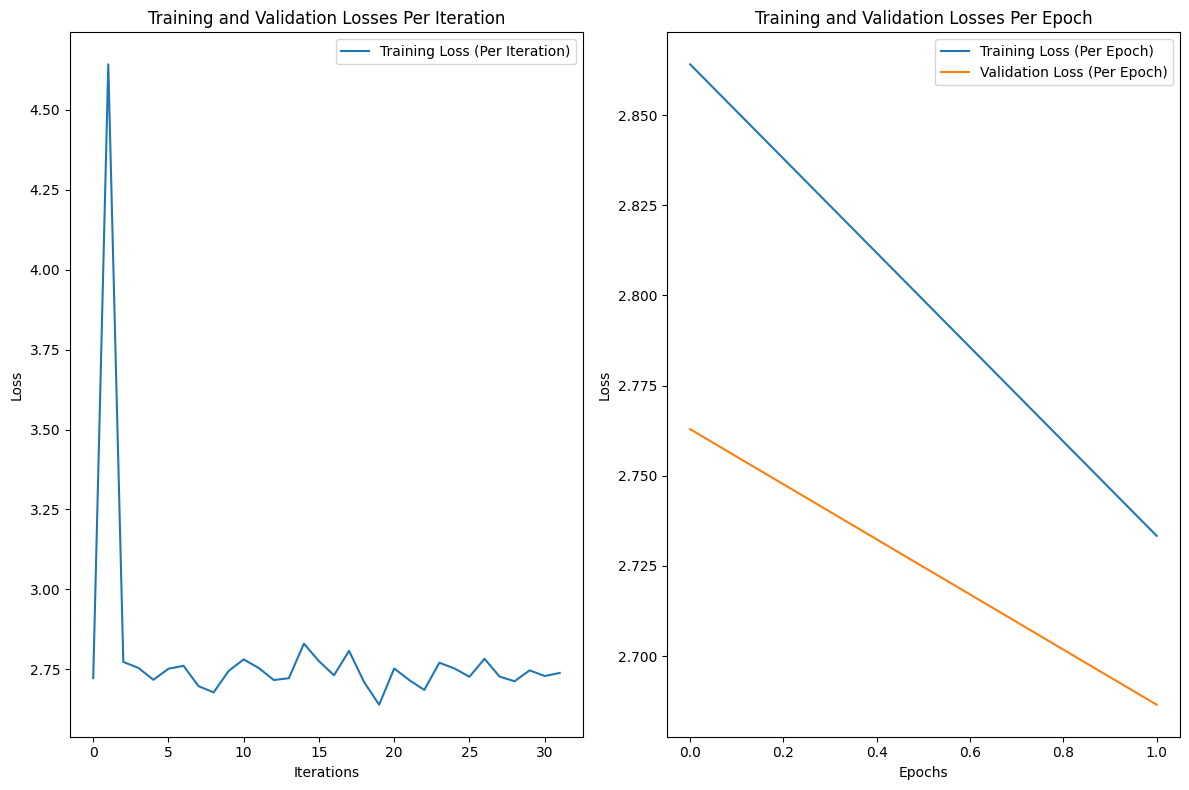

In [16]:
# Train and validate the model
trained_model = train_labrador(model, train_loader, test_loader, categorical_loss_fn, continuous_loss_fn, optimizer='Adam', num_epochs=2, device=device, save_model=False, model_path='labrador_model.pth')